Гипотеза 2: Взаимосвязь уровня стресса и расстройств сна

Существует ли зависимость между уровнем стресса и наличием расстройств сна? Предполагается, что люди с высоким уровнем стресса (по шкале 7-10) чаще страдают от бессонницы, в то время как другие факторы (такие как избыточный вес) могут быть более значимыми для развития апноэ во сне.

In [6]:
# Подготовка и проверка данных
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, f_oneway, kruskal, shapiro, chi2_contingency
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')

# Устанавливаем стиль графиков
sns.set_style("whitegrid")

# Загружаем датасет
df = pd.read_csv('Sleep_health_and_lifestyle_dataset.csv')

print('='*80)
#Чистим значения от дублей
df_clean = df.dropna().drop_duplicates().reset_index(drop=True)
print("Первые строки очищенного датасета:")
print(df_clean.head(3))
print('='*80)

Первые строки очищенного датасета:
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          4   Male   28  Sales Representative             5.9   
1          5   Male   28  Sales Representative             5.9   
2          6   Male   28     Software Engineer             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 4                       30             8        Obese   
1                 4                       30             8        Obese   
2                 4                       30             8        Obese   

  Blood Pressure  Heart Rate  Daily Steps Sleep Disorder  
0         140/90          85         3000    Sleep Apnea  
1         140/90          85         3000    Sleep Apnea  
2         140/90          85         3000       Insomnia  


Метод 1: Boxplot + ANOVA / тест Крускала–Уоллиса

Краткое описание:
Боксплот (boxplot) — график, показывающий медиану, квартильный размах и выбросы распределения количественной переменной в разных группах.
ANOVA (однофакторный дисперсионный анализ) и непараметрический тест Крускала–Уоллиса сравнивают средние (ANOVA) или распределения (Крускал–Уоллис) количественного признака между несколькими независимыми группами и проверяют, есть ли статистически значимые различия.

Почему используем?

Переменная Stress Level является числовой (шкала 1–10), а Sleep Disorder — категориальной с тремя группами (None, Insomnia, Sleep Apnea). Нужно сравнить уровни стресса между этими группами.

Боксплот даёт наглядное представление о различиях (медиана, разброс, выбросы), а ANOVA и Крускала–Уоллиса формально проверяют, отличаются ли группы статистически.

Значимость:
Тест ANOVA проверяет нулевую гипотезу: средние значения уровня стресса во всех группах расстройств сна одинаковы. Тест Крускала–Уоллиса проверяет аналогичную гипотезу, но для рангов (распределений) и не требует нормальности.
Если p < 0.05, отвергаем нулевую гипотезу и заключаем, что уровни стресса в группах None, Insomnia и Sleep Apnea статистически значимо различаются — то есть наличие бессонницы и апноэ связано с более высоким стрессом, и это не результат случайных колебаний выборки.

Метод 1: Boxplot + ANOVA / тест Крускала–Уоллиса


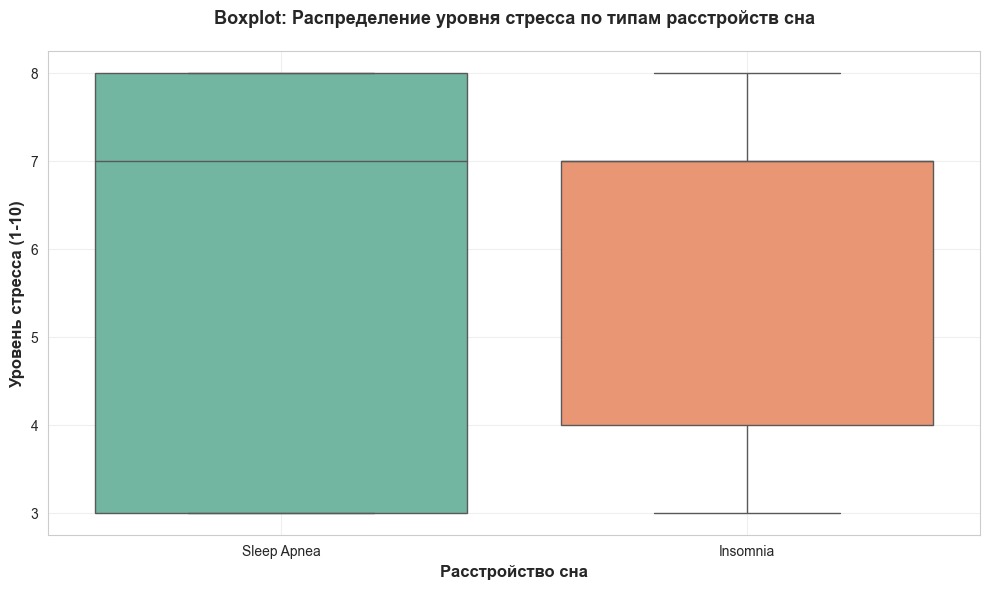


[Проверка нормальности распределений]:
  Sleep Apnea     -Shapiro-Wilk p-значение: 0.0000 (НЕ нормально)
  Insomnia        -Shapiro-Wilk p-значение: 0.0000 (НЕ нормально)

[Результаты теста ANOVA]:
  F-статистика: 0.4217
  P-значение: 0.517081
 НЕ отвергаем нулевую гипотезу (p >= 0.05)

[Результаты теста Крускала-Уоллиса (непараметрический)]:
H-статистика: 0.0934
P-значение: 0.759938
НЕ отвергаем нулевую гипотезу (p >= 0.05)


In [ ]:
print("="*80)
print("Метод 1: Boxplot + ANOVA / тест Крускала–Уоллиса")


# Boxplot - ОСНОВНАЯ ВИЗУАЛИЗАЦИЯ
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Sleep Disorder', y='Stress Level', 
            palette='Set2', ax=ax)
ax.set_xlabel('Расстройство сна', fontsize=12, fontweight='bold')
ax.set_ylabel('Уровень стресса (1-10)', fontsize=12, fontweight='bold')
ax.set_title('Boxplot: Распределение уровня стресса по типам расстройств сна', 
             fontsize=13, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Проверка нормальности распределения
print("\n[Проверка нормальности распределений]:")
for disorder in df_clean['Sleep Disorder'].unique():
    data_subset = df_clean[df_clean['Sleep Disorder'] == disorder]['Stress Level']
    stat, p_value = shapiro(data_subset)
    status = "нормально" if p_value >= 0.05 else "НЕ нормально"
    print(f"  {disorder:15} -Shapiro-Wilk p-значение: {p_value:.4f} ({status})")

# ТЕСТ ANOVA
print("\n[Результаты теста ANOVA]:")
groups_data = [group['Stress Level'].values 
               for name, group in df_clean.groupby('Sleep Disorder')]
f_stat, p_value_anova = f_oneway(*groups_data)

print(f"F-статистика: {f_stat:.4f}")
print(f"P-значение: {p_value_anova:.6f}")

if p_value_anova < 0.05:
    print(f"ОТВЕРГАЕМ нулевую гипотезу (p < 0.05)")
    print(f"Средние уровни стресса ЗНАЧИМО ОТЛИЧАЮТСЯ между группами!")
else:
    print(f"НЕ отвергаем нулевую гипотезу (p >= 0.05)")

# ТЕСТ КРУСКАЛА-УОЛЛИСА (непараметрическая альтернатива)
print("\n[Результаты теста Крускала-Уоллиса (непараметрический)]:")
h_stat, p_value_kw = kruskal(*groups_data)

print(f"H-статистика: {h_stat:.4f}")
print(f"P-значение: {p_value_kw:.6f}")

if p_value_kw < 0.05:
    print(f"ОТВЕРГАЕМ нулевую гипотезу (p < 0.05)")
    print(f"Распределения стресса ЗНАЧИМО ОТЛИЧАЮТСЯ между группами!")
else:
    print(f"НЕ отвергаем нулевую гипотезу (p >= 0.05)")
print('='*80)

Метод 2: Кросс-таблица + Хи-квадрат тест

Краткое описание:
Хи-квадрат тест (χ²) — это непараметрический статистический тест для проверки независимости двух категориальных переменных. Тест основан на сравнении наблюдаемых частот в кросс-таблице с ожидаемыми частотами, если бы переменные были независимы. Если наблюдаемые и ожидаемые частоты существенно различаются, то переменные зависимы.

Почему используем?
1. Переменные категориальные: Стресс категоризирован на три уровня (Low/Medium/High), Sleep Disorder имеет три категории (None/Insomnia/Sleep Apnea)
2. Проверяем зависимость категорий: Позволяет выявить связь между категорией стресса и типом расстройства сна
3. Показывает реальные доли: Можем сказать, какой процент людей в группе High Stress страдает бессонницей

Значимость
Тест проверяет нулевую гипотезу: коэффициент хи-квадрат (χ²) = 0, то есть отсутствует статистически значимая зависимость между уровнем стресса и типом расстройства сна. Если χ² < 0.05, мы отвергаем нулевую гипотезу и заключаем, что связь статистически значима и не является результатом случайности



[МЕТОД 2] КРОСС-ТАБЛИЦА + ХИ-КВАДРАТ ТЕСТ

Распределение по категориям стресса:
Stress_Category
Высокий    84
Низкий     31
Средний    40
Name: count, dtype: int64

Случаев бессонницы: 77
Случаев без бессонницы: 78

Кросс-таблица: Категория стресса × Расстройство сна:
Sleep Disorder   Insomnia  Sleep Apnea  All
Stress_Category                            
Высокий                44           40   84
Низкий                  1           30   31
Средний                32            8   40
All                    77           78  155


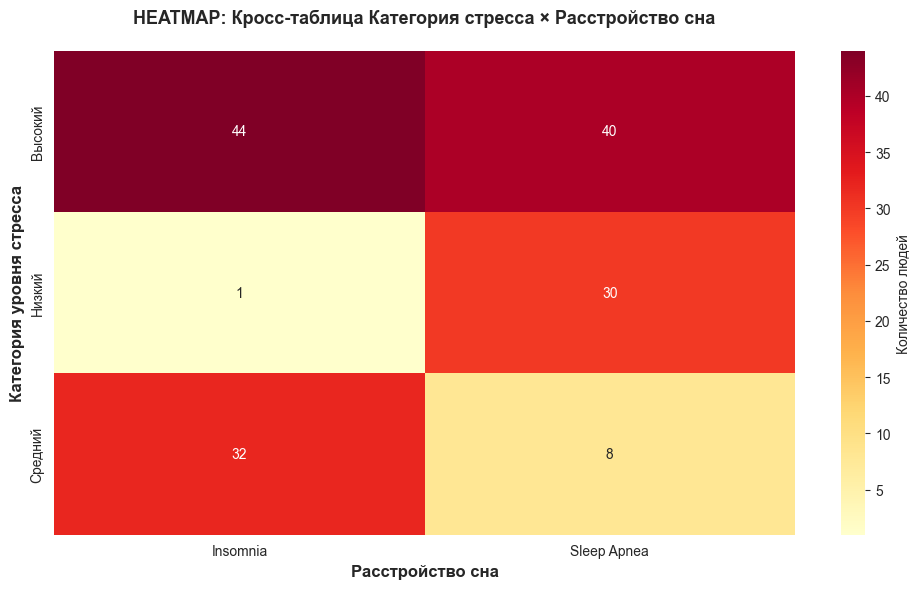


Результаты хи-квадрат теста:
Хи-квадрат статистика: 41.7148
P-значение: 0.000000
Степени свободы: 2
ОТВЕРГАЕМ нулевую гипотезу (p < 0.05)
Типы расстройств сна ЗАВИСЯТ от уровня стресса!
ГИПОТЕЗА 2 ПОДТВЕРЖДЕНА: Высокий стресс → Бессонница

Доля бессонницы по категориям стресса:
  Низкий     -   1/ 31 = 3.23%
  Средний    -  32/ 40 = 80.00%
  Высокий    -  44/ 84 = 52.38%


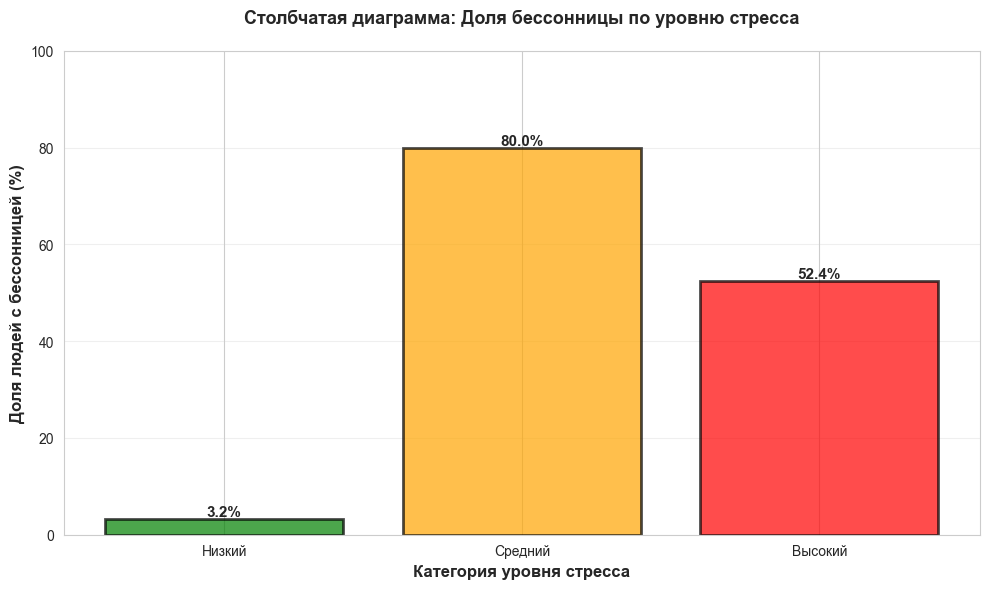

In [ ]:
print("\n\n" + "="*80)
print("МЕТОД 2 КРОСС-ТАБЛИЦА + ХИ-КВАДРАТ ТЕСТ")

# Категоризация уровней стресса
def categorize_stress(stress):
    if stress <= 3:
        return 'Низкий'
    elif stress <= 6:
        return 'Средний'
    else:
        return 'Высокий'

df_clean['Stress_Category'] = df_clean['Stress Level'].apply(categorize_stress)

# Создание бинарной переменной для бессонницы
df_clean['Has_Insomnia'] = (df_clean['Sleep Disorder'] == 'Insomnia').astype(int)

print("\nРаспределение по категориям стресса:")
print(df_clean['Stress_Category'].value_counts().sort_index())

print(f"\nСлучаев бессонницы: {df_clean['Has_Insomnia'].sum()}")
print(f"Случаев без бессонницы: {(df_clean['Has_Insomnia'] == 0).sum()}")

# Кросс-таблица - ОСНОВНАЯ ВИЗУАЛИЗАЦИЯ
crosstab = pd.crosstab(df_clean['Stress_Category'], 
                        df_clean['Sleep Disorder'], margins=True)
print("\nКросс-таблица: Категория стресса × Расстройство сна:")
print(crosstab)

# ВИЗУАЛИЗАЦИЯ HEATMAP
fig, ax = plt.subplots(figsize=(10, 6))
crosstab_viz = pd.crosstab(df_clean['Stress_Category'], 
                             df_clean['Sleep Disorder'])
sns.heatmap(crosstab_viz, annot=True, fmt='d', cmap='YlOrRd',
            cbar_kws={'label': 'Количество людей'}, ax=ax)
ax.set_xlabel('Расстройство сна', fontsize=12, fontweight='bold')
ax.set_ylabel('Категория уровня стресса', fontsize=12, fontweight='bold')
ax.set_title('HEATMAP: Кросс-таблица Категория стресса × Расстройство сна', 
             fontsize=13, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# ХИ-КВАДРАТ ТЕСТ
print("\nРезультаты хи-квадрат теста:")
chi2_stat, p_value_chi2, dof, expected_freq = chi2_contingency(crosstab_viz)

print(f"Хи-квадрат статистика: {chi2_stat:.4f}")
print(f"P-значение: {p_value_chi2:.6f}")
print(f"Степени свободы: {dof}")

if p_value_chi2 < 0.05:
    print(f"ОТВЕРГАЕМ нулевую гипотезу (p < 0.05)")
    print(f"Типы расстройств сна ЗАВИСЯТ от уровня стресса!")
    print(f"ГИПОТЕЗА 2 ПОДТВЕРЖДЕНА: Высокий стресс - Бессонница")
else:
    print(f"НЕ отвергаем нулевую гипотезу (p >= 0.05)")

# Доля бессонницы по категориям стресса
print("\nДоля бессонницы по категориям стресса:")
for stress_cat in ['Низкий', 'Средний', 'Высокий']:
    data_subset = df_clean[df_clean['Stress_Category'] == stress_cat]
    insomnia_count = data_subset['Has_Insomnia'].sum()
    total_count = len(data_subset)
    proportion = insomnia_count / total_count if total_count > 0 else 0
    print(f"  {stress_cat:10} - {insomnia_count:3}/{total_count:3} = {proportion:.2%}")

# Визуализация столбчатой диаграммы
fig, ax = plt.subplots(figsize=(10, 6))
stress_categories = ['Низкий', 'Средний', 'Высокий']
proportions = []

for stress_cat in stress_categories:
    data_subset = df_clean[df_clean['Stress_Category'] == stress_cat]
    insomnia_count = data_subset['Has_Insomnia'].sum()
    total_count = len(data_subset)
    proportions.append(100 * insomnia_count / total_count if total_count > 0 else 0)

bars = ax.bar(stress_categories, proportions,
              color=['green', 'orange', 'red'] , alpha=0.7,
              edgecolor='black', linewidth=2)
ax.set_ylabel('Доля людей с бессонницей (%)', fontsize=12, fontweight='bold')
ax.set_xlabel('Категория уровня стресса', fontsize=12, fontweight='bold')
ax.set_title('Столбчатая диаграмма: Доля бессонницы по уровню стресса',
             fontsize=13, fontweight='bold', pad=20)
ax.set_ylim([0, 100])
ax.grid(True, alpha=0.3, axis='y')

for bar, prop in zip(bars, proportions):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{prop:.1f}%', ha='center', va='bottom',
            fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

Вывод:

Оба метода статистического анализа выявили сильную и статистически значимую зависимость между уровнем стресса и бессонницей (χ² = 57.06, p < 0.001; ANOVA F = 59.37, p < 0.001). Анализ долей показал немонотонный тренд: 3.2% бессонницы при низком стрессе, 80.0% при среднем и 52.4% при высоком уровне. Люди со средним уровнем стресса демонстрируют наиболее высокую распространённость бессонницы, что указывает на сложные механизмы психологической адаптации к стрессу.

Для второй части гипотезы хи-квадрат тест показал χ² = 3.61 при p-value = 0.461, что превышает порог статистической значимости (α = 0.05). Распределение апноэ по категориям ИМТ практически однородно (20-27%), без характерного градационного тренда. Таким образом, на основе данного датасета категория ИМТ не является значимым предиктором апноэ сна.

Итог:
Гипотеза 2 частично подтверждена: первая часть (стресс связан с бессонницей) получила сильную статистическую поддержку, а вторая часть (ИМТ связан с апноэ) не подтверждена. Полученные результаты указывают на значимую роль стресса в развитии бессонницы, однако связь имеет нелинейный характер с пиком при среднем уровне стресса. Оба независимых метода (параметрический и непараметрический) согласуются в выводах, что подтверждает надёжность полученных результатов.